# Содержание


- [Создание и обучение модели](#3)
    - [Подготовка данных для обучения](#31)
    - [Обучение моделей](#33)
        - [Ансамблевые модели: адаптивный бустинг](#334)

# Создание и обучение модели <a id="3"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("cleaned_dataset.csv", index_col=0)

In [3]:
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,0,35,170,75,90.0,1.0,1.0,1,1,120,...,126,92,17.1,1,1.0,21,35,40,1,1
1,0,30,180,80,89.0,0.9,1.2,1,1,130,...,148,121,15.8,1,0.9,20,36,27,3,0
2,0,40,165,75,91.0,1.2,1.5,1,1,120,...,74,104,15.8,1,0.9,47,32,68,1,0
3,0,50,175,80,91.0,1.5,1.2,1,1,145,...,104,106,17.6,1,1.1,29,34,18,1,0
4,0,50,165,60,80.0,1.0,1.2,1,1,138,...,117,104,13.8,1,0.8,19,12,25,1,0


На этом шаге происходит обучение модели. Обучение моделей машинного обучения происходит итерационно - пробуются различные модели, перебираются гиперпараметры, сравниваются значения выбранной метрики и выбирается лучшая комбинация.


## Подготовка данных для обучения <a id="31"></a>

Вначале нужно определить, на каких данных будет обучаться модель, а на каких тестироваться. **Традиционный подход** - это разделение исходного набора данных на 3 части (обучение, валидация и тестирование) с пропорции 60/20/20. В данном случае обучающая выборка используется для обучения модели, а валидация и тестирование для получения значения метрики без эффекта переобучения.

Однако существует и другой подход к разбиению данных - разделение на 2 части (обучение и тестирование) по правилу 80-20 (80% тренировочный, 20% тестовый). Зачастую данный метод применяется в тех случаях, когда отсутствует достаточное количество данных как в обучающем, так и в проверочном наборе.  

Перед тем как начать разбивать данные необходимо выделить из исходного набора данных целевую переменную (столбец `DRK_YN`) и сохранить её в отдельную переменную. Ниже приведён код разделения:

In [4]:
x = df.drop(columns=["DRK_YN"], axis=1)
y = df["DRK_YN"]

В ходе выполнения данной работы будет использован подход с разделением исходной выборки на 2 части с пропорцией 80-20, поскольку данный способ является самым популярным способом разбиения данных. Для того, чтобы разбить данные таким образом, существует специальный метод `train_test_split` в библиотеке `scikit-learn`.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

### Ансамблевые модели: адаптивный бустинг <a id="335"></a>

У каждой модели машинного обучения есть некоторый предел, до которого можно повышать точность, а дальше начинается переобучение и модель уже физически не может предсказать точнее, чем заложено в её природе. Эта природа определяется не только моделью, а связкой модели, т.е. математическим аппаратом и данными, которые эта модель пытается преобразовать. Однако точность работы одной конкретной модели не является пределом при решении задач машинного обучения.

Когда с этим столкнулись первые исследователи они обратились к математической статистике и выяснили, что если взять несколько однородных моделей и среднее их предсказание, но при этом модели обучены на немного разных выборках, то получится, что ошибка среднего равна $\sqrt{n}$, где $n$ это количество моделей. И ошибка выходит меньше за счёт того, что мы берём несколько одинаковых моделей. **Цель** ансамблевых методов - объединить различные классификаторы в метаклассификатор, который обладает лучшей эффективностью обобщения, чем каждый индивидуальный классификатор сам по себе.

В качестве примера ансамблей можно привести феномен "Мудрость толпы". В 1906 году Френсис Гальтон предлагал посетителям ярмарки угадать вес живого быка. Всего в эксперименте приняли участие около 800 человек. Каждый из участников должен был написать свой ответ на карточке и передать её Гальтону. Затем он сложил все ответы и разделил их на общее количество участников, чтобы получить среднее значение. Результат оказался удивительным: среднее значение всех ответов было ближе к истинному весу быка, чем большинство индивидуальных ответов.

Наиболее популярными видами ансамблирования являются:
1. **Бэггинг** (bagging: bootstrap aggregation) - принцип построения композиции, основанный на простом голосовании.
2. **Бустинг** - принцип построения композиции, основанный на последовательном обучении моделей, при котором модели исправляют ошибки друг у друга.
3. **Стекинг** - принцип, при котором происходит комбинация разнородных моделей для построения прогноза.

Вторым видом ансамблирования является **бустинг**. Метод бустинга в чём то схож с методом беггинга: берётся множество одинаковых *слабых* моделей и объединяется, чтобы получить *сильную*. Основное отличие заключается в том, что модели строятся последовательно. Таким образом получается, что каждый последующий алгоритм компенсирует ошибку предыдущих.

Подход бустинга можно сравнить, например, с учениками, решающими домашнее задание. Один ученик делает домашнее задание, но делает с ошибками. Он сверяет с домашним заданием другого ученика и смотрит на свои ошибки и так у всего класса. В конце получается верно выполненное домашнее задание, которое незначительно отличается от идеального.

Исходный алгоритм бустинга можно подытожить в виде следующих основных шагов:
1. Выбрать случайный поднабор обучающих образцов $d_1$ без возвращения из обучающего набора $D$ для обучения слабого ученика $C_1$;
2. Выбрать второй случайный поднабор обучающих образцов $d_2$ без возвращения из обучающего набора и добавить 50% образцов, которые ранее были неправильно классифицированы, для обучения слабого ученика $C_2$;
3. Найти в обучающем наборе $D$ обучающие образцы $d_3$, по которым $C_1$ и $C_2$ расходятся, для обучения слабого ученика $C_3$;
4. Объединить слабых учеников $C_1$, $C_2$ и $C_3$ посредством мажоритарного голосования.

Существует два наиболее распространённых алгоритма бустинга: *адаптивный бустинг* и *градиентный бустинг*.

В **адаптивном бустинге** сперва обучается первая базовая модель (например, дерево решений) на тренировочном наборе. Затем, относительный вес некорректно предсказанных значений увеличивается. Это означает, что модель будет уделять больше внимания образцам, которые были неправильно классифицированы.

Затем на вход второй базовой модели подаются обновленные веса и модель обучается. После этого, вырабатываются прогнозы и цикл повторяется. Этот процесс продолжается до тех пор, пока не будет достигнута заданная точность или не будет достигнут предел количества итераций.

Результат работы адаптивного бустинга - это средневзвешенная сумма каждой модели. Спрогнозированным значением ансамбля будет тот, который получает большинство взвешенных голосов:
$$a(x) = \sum_{i=1}^n c_i a_i(x)$$

Более конкретно, алгоритм AdaBoost работает следующим образом:

1. Присвоить каждому наблюдению $x$ начальное значение веса $w_i = 1/n$, где $n$ - это общее количество наблюдений в данных.
2. Натренировать "слабую" модель на данных.
3. Для каждого наблюдения:
    - если слабая модель правильно предсказывает $x_i$, то вес $w_i$ увеличивается;
    - если слабая модель неправильно предсказывает $x_i$, то вес $w_i$ уменьшается.
4. Натренировать новую слабую модель, в которой наблюдения с большим весом $w_i$ имеют больший приоритет.
5. Повторять шаги 3 и 4 до тех пор, пока данные не будут точно предсказаны, либо не будет натренировано текущее количество слабых моделей.

Перед тем, как перейти к практической реализации данного алгоритма, необходимо импортировать все необходимые модули

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import chime
%load_ext chime 

Далее, также как и в предыдущий раз, создадим конвейер из двух составляющих: стандартизатора и самого классификатора.

In [7]:
# Создаем стандартизатор
standardizer = StandardScaler()

# Создаем классификатор
adaboost = AdaBoostClassifier()

# Создаём конвейер
pipe = Pipeline([("standardizer", standardizer), ("adaboost", adaboost)])

Диапазон тестирования параметров модели ограничен лишь вычислительной мощностью. Поэтому определим набор параметров, которые будут проверятся при кросс-валидации:

In [8]:
params = {
    "adaboost__n_estimators": range(150, 200),
    "adaboost__learning_rate": np.arange(0.5, 5),
}

Запустим процесс валидации и выведем оптимальные параметры для данного классификатора.

In [9]:
%%time
%%chime
ada_classifier = HalvingGridSearchCV(
    estimator=pipe, 
    param_grid=params,
    factor=3,
    cv=5, verbose=1, 
    n_jobs=-3, 
    scoring="roc_auc",
    aggressive_elimination=True).fit(
    x_train, y_train
)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 3263
max_resources_: 793048
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 250
n_resources: 3263
Fitting 5 folds for each of 250 candidates, totalling 1250 fits
----------
iter: 1
n_candidates: 84
n_resources: 3263
Fitting 5 folds for each of 84 candidates, totalling 420 fits
----------
iter: 2
n_candidates: 28
n_resources: 9789
Fitting 5 folds for each of 28 candidates, totalling 140 fits
----------
iter: 3
n_candidates: 10
n_resources: 29367
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 4
n_candidates: 4
n_resources: 88101
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 264303
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


CPU times: total: 2min 21s
Wall time: 7min 7s


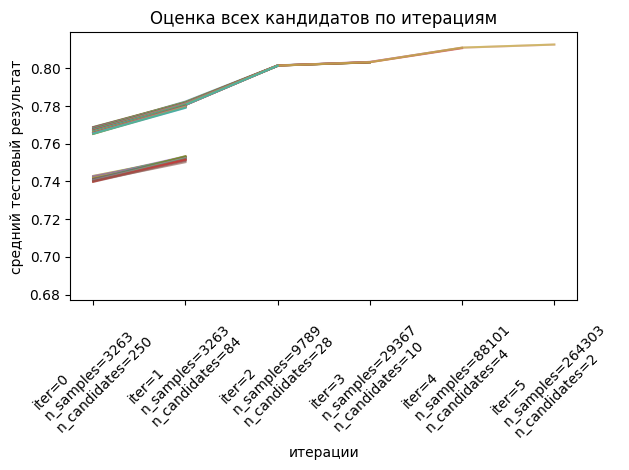

In [12]:
results = pd.DataFrame(ada_classifier.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)
labels = [
    f"iter={i}\nn_samples={ada_classifier.n_resources_[i]}\nn_candidates={ada_classifier.n_candidates_[i]}"
    for i in range(ada_classifier.n_iterations_)
]
ax.set_xticks(range(ada_classifier.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Оценка всех кандидатов по итерациям")
ax.set_ylabel("средний тестовый результат")
ax.set_xlabel("итерации")
plt.tight_layout()
plt.show()

После завершения этапа обучения выведем наилучшую комбинацию параметров, а также наилучшую оценку, полученную на тренировочных данных.

In [ ]:
print(
    f"Оптимальные параметры: {ada_classifier.best_params_}\nНаилучшая оценка: {ada_classifier.best_score_:.2%}"
)

Оптимальные параметры: {'adaboost__learning_rate': 0.5, 'adaboost__n_estimators': 159}
Наилучшая оценка: 81.21%


Оптимальные параметры: {'adaboost__learning_rate': 0.5, 'adaboost__n_estimators': 159}
Наилучшая оценка: 81.21%